# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.dnd.game_board import DnDBoard
from src.agent.agent import DnDAgent
from src.agent.agent_utils import get_default_action_resolver, get_states, self_play_loop
from src.agent.training import train_loop_trivial

In [3]:
seed_everything(1234)

## Sample agent game

In [4]:
def custom_reward(game, unit: Unit, player_id: int, move_legal: bool, action_legal: bool, updates: dict):
        units_removed = updates['units_removed']
        reward = -0.05
        game_over = False
        # reward for removing enemy units, 1 for each unit
        reward += len([x for x in units_removed if x[1] != player_id])
        # reward for defeating players
        reward += 5 * len([x for x in units_removed if len(game.players_to_units[x[1]]) == 0 and x[1] != player_id])
        # reward for winning
        if len(game.players_to_units[player_id]) == len(game.units):
            game_over = True
            reward += 10
        # penalty for losing (on your own turn ??)
        if len(game.players_to_units[player_id]) == 0:
            game_over = True
            reward = -10
        
        return reward, game_over

In [5]:
def create_same_game(board_size=(5, 5), show_game=False, get_colormap=True, reward_head=None):
    game = DnDBoard(board_size, reward_head=reward_head)

    ally = GenericSoldier("Ally soldier", attack_damage=25)
    ally2 = GenericSoldier("Ally soldier", attack_damage=25, health=50, range=4)
    #ally2 = GenericSoldier("Ally archer", health=50, attack_damage=25, speed=4, range=8)
    enemy = GenericSoldier("Enemy soldier", attack_damage=25)
    enemy2 = GenericSoldier("Enemy soldier", attack_damage=25, health=50, range=4)
    #enemy2 = GenericSoldier("Enemy archer", health=50, attack_damage=25, speed=4, range=8)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
    place_unit_randomly(game, ally2, 0)
    place_unit_randomly(game, enemy2, 1)
   
    game.initialize_game()

    if get_colormap or show_game:
        color_map = {
            ally: "Green",
            enemy: "Red",
            ally2: "Green",
            enemy2: "Red",
            #ally2: "Blue",
            #enemy2: "Purple"
        }

        if show_game: print_game(game, color_map)

        return game, color_map

    return game

In [6]:
# next state is delayed and can be inconsistent. Enemy reward is your punishment
def train_loop_delayed(agent: DnDAgent, game: DnDBoard, random_action_resolver=None) -> int:
    game_over = False
    iter_count = 0
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_count += 1
    
        state, action_vector, new_coords, action = get_states(game, agent, random_action_resolver)
        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_vector, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_vector
        last_reward = reward

    return iter_count

In [7]:
board_shape = (5, 5)
agent = DnDAgent(board_shape=board_shape, in_channels=8, out_actions=2, 
    lr=1e-3, 
    epsilon=0.1, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='linear',
    gamma=0.9,
    batch_size=32, 
    dual_learning=True, 
    replace_model_interval=5000,
    memory_capacity=100000
)

train_loop = train_loop_trivial
reward_policy = None

In [8]:
reports_path = '../config-log/2v2-0/'
generation_name = 'gen28'
gen_header = \
'''# Based on gen26

## Differences:

* Fixed handling of illegal moves / actions
'''

In [9]:
iters, eps, checkpoints, reps = [], [], [], []
mag1s, mag2s = [], []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace

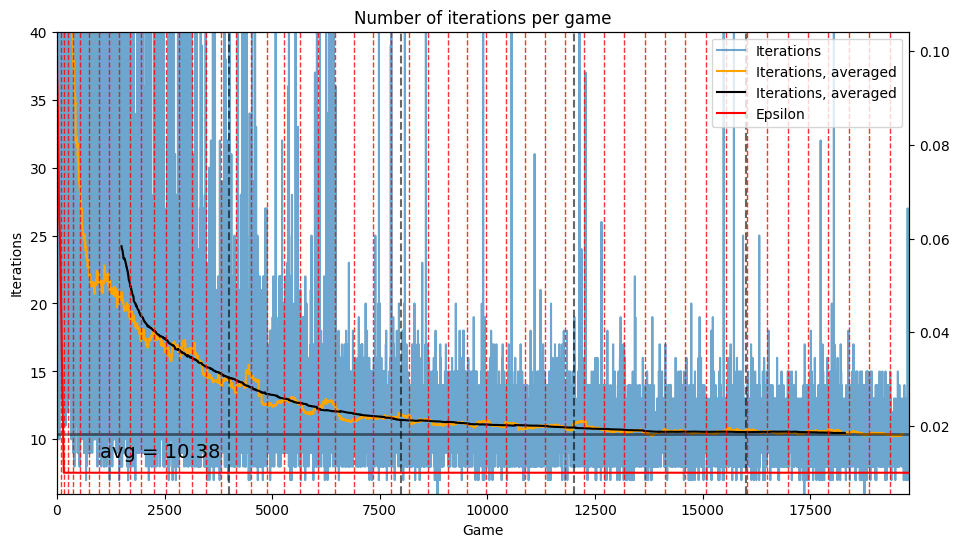

Training:  99%|#########9| 19801/20000 [36:08<00:18, 10.73it/s, mag1=63.5, mag2=42.4]

In [10]:
games = 20000
checkpoint_each = 4000
checkpoint_name = f'2v2-0-agent-{generation_name}'
if checkpoint_name is None: checkpoint_each = 1e99
last_update = time.time()

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = create_same_game(board_shape, get_colormap=False, reward_head=reward_policy)
        resolver = get_default_action_resolver(game)
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        iter_count = train_loop(agent, game, resolver)
        iters.append(iter_count)
        eps.append(agent.epsilon)
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        ctime = time.time()
        if ctime - last_update > 20:
            clear_output(wait=True)
            plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=40)
            display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_each:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-1000:]) # recent performance
            agent.save_agent(f'../checkpoints/{checkpoint_name}-{avg:0.1f}i-{iter_i}')

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)

In [11]:
export_path = os.path.join(reports_path, generation_name)
os.makedirs(export_path)

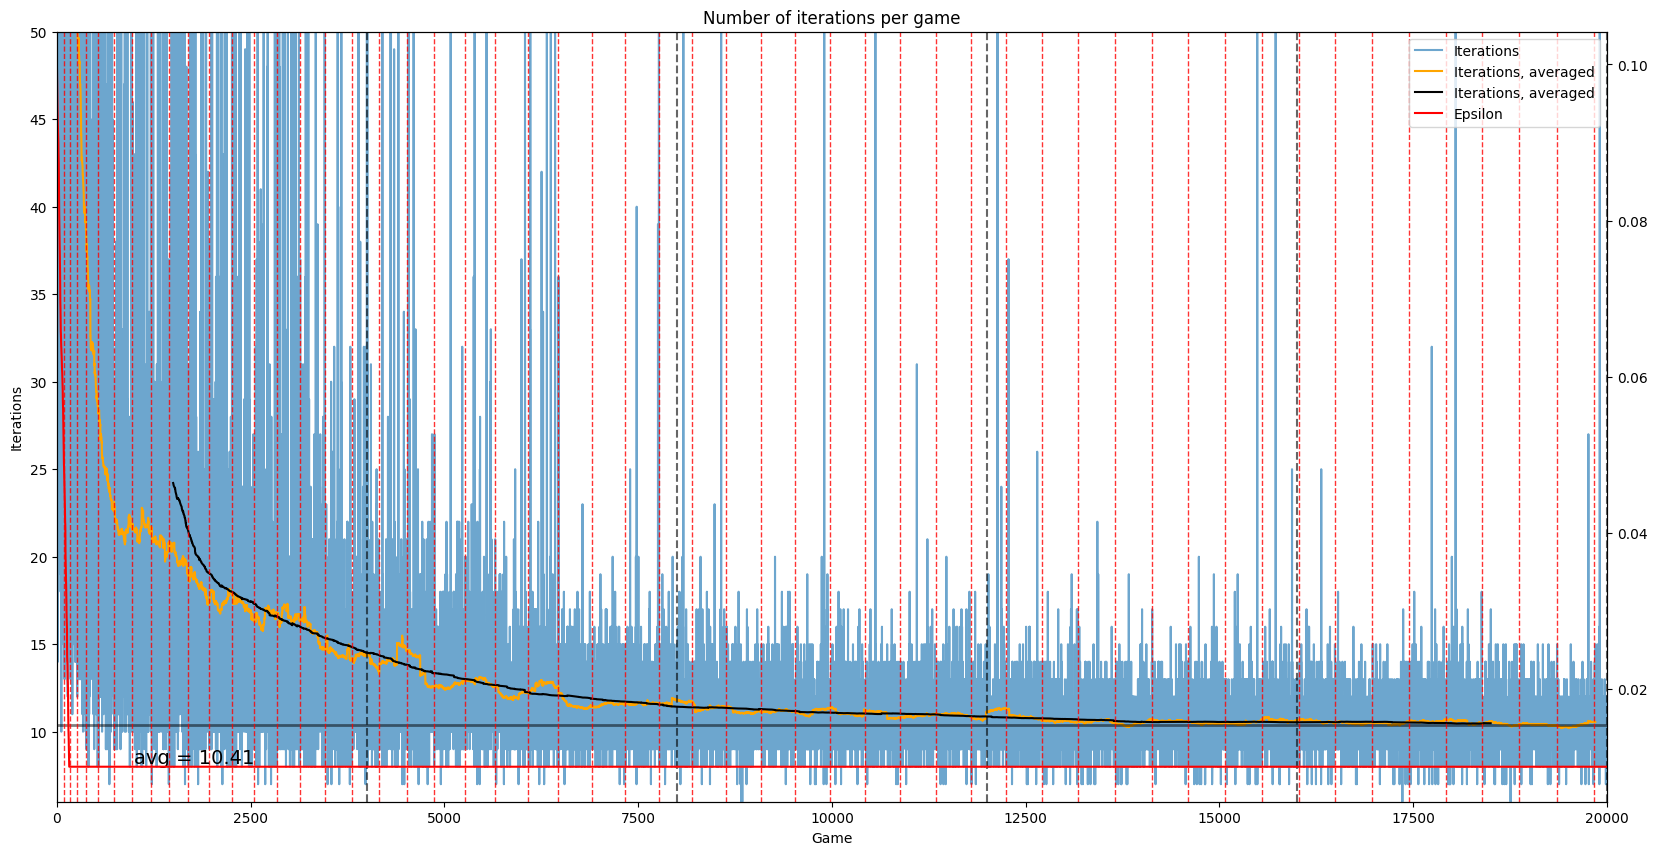

In [12]:
plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=50, figsize=(20, 10), show=False)
plt.savefig(os.path.join(export_path, 'training.png'), bbox_inches='tight')
plt.show()

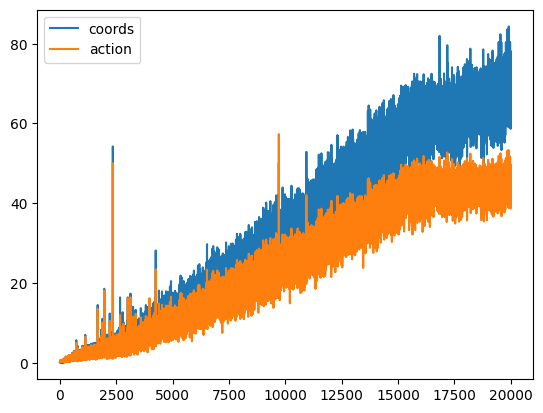

Total number of iterations: 266796


In [13]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(export_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [14]:
with open(os.path.join(export_path, 'report.md'), 'w') as report:
    avg = np.mean(iters[-1000:])
    total = np.sum(iters)
    perf = 1e9 / (avg * total)
    report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after 20k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")
''')

In [15]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 6
Longest game: 633
Number of shortest games: 4


In [16]:
game, color_map = create_same_game()

self_play_loop(agent, game, color_map, reset_epsilon=True, delay=1)

Iteration: 10
Turn made by player #0: `Ally soldier`:
	Unit moves: (1, 2) -> (1, 3);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'Enemy soldier'}

Units alive: 1
Players: 2:
	Player #0 (1 units): `Ally soldier (50 HP)`,   
	Player #1 (0 units):   
	
    0 1 2 3 4
 0            0 
 1     ██     1 
 2            2 
 3            3 
 4            4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`

Game over in 10 iterations


10

# Visualization

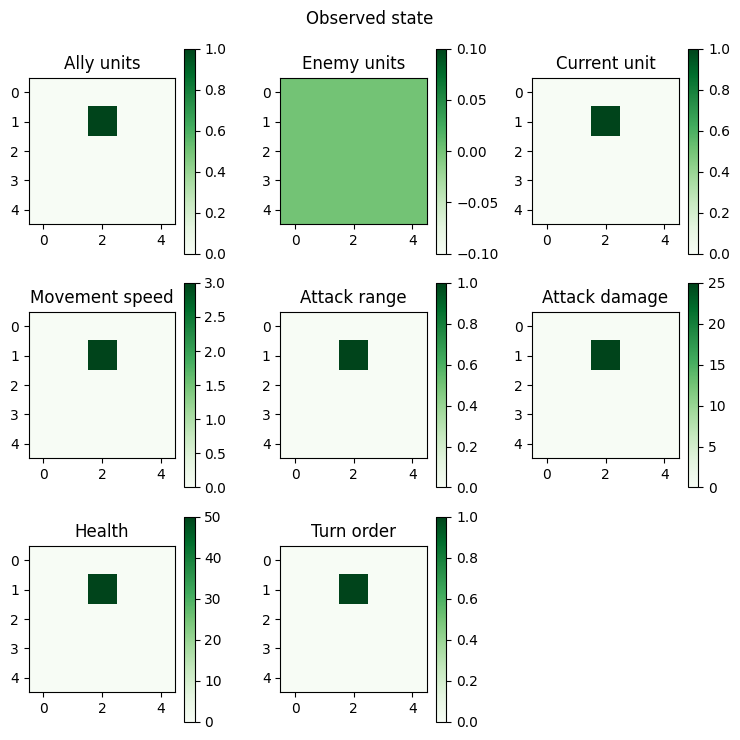

In [17]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.get_featuremap_names(),
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [18]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally soldier (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy soldier (50 HP)`  
	
    0 1 2 3 4
 0 ██         0 
 1   ██       1 
 2   ██       2 
 3 ██         3 
 4            4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`


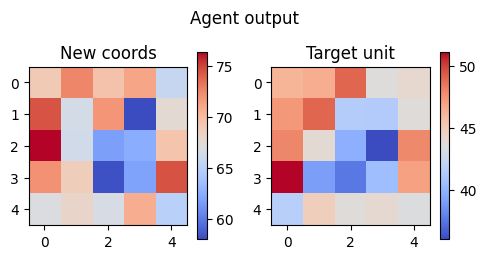

(array([2, 3], dtype=int64), array([0, 0], dtype=int64))


In [19]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))